# Open University Analysis
## Author - Akanksha Rawat

### Importing the Packages

In [1]:
import numpy as np
import pandas as pd
import re
import pandas_profiling as pp
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt
from pdpbox import pdp, get_dataset, info_plots
from xgboost import plot_importance
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
# import shap

In [3]:
import warnings
warnings.filterwarnings("ignore")

### Loading the Data

In [4]:
courses = pd.read_csv('Dataset/courses.csv',na_values = '?')
studentInfo = pd.read_csv('Dataset/studentInfo.csv',na_values = '?')
studentRegistration = pd.read_csv('Dataset/studentRegistration.csv',na_values='?')
studentVle = pd.read_csv('Dataset/studentVle.csv',na_values = '?')


### High level Analysis of Data

#### 1. Analysing the courses data

In [5]:
pp.ProfileReport(courses)

Number of variables,3
Number of observations,22
Total Missing (%),0.0%
Total size in memory,608.0 B
Average record size in memory,27.6 B
Numeric,1
Categorical,2
Boolean,0
Date,0
Text (Unique),0
Rejected,0


#### 2. Analyzing the studentInfo data

In [6]:
pp.ProfileReport(studentInfo)

Number of variables,12
Number of observations,32593
Total Missing (%),0.3%
Total size in memory,3.0 MiB
Average record size in memory,96.0 B
Numeric,3
Categorical,9
Boolean,0
Date,0
Text (Unique),0
Rejected,0


#### 3. Analyzing the studentRegistration data

In [7]:
pp.ProfileReport(studentRegistration)

Number of variables,5
Number of observations,32593
Total Missing (%),13.8%
Total size in memory,1.2 MiB
Average record size in memory,40.0 B
Numeric,3
Categorical,2
Boolean,0
Date,0
Text (Unique),0
Rejected,0


#### 4. Analyzing the studentVle data

In [8]:
pp.ProfileReport(studentVle)

Number of variables,6
Number of observations,10655280
Total Missing (%),0.0%
Total size in memory,487.8 MiB
Average record size in memory,48.0 B
Numeric,4
Categorical,2
Boolean,0
Date,0
Text (Unique),0
Rejected,0


#### The above profile report suggests that studentVle has 787170 duplicate entries.

#### Removing the duplicate data

In [9]:
studentVle = studentVle.drop_duplicates()

In [10]:
studentVle.head()

,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546652,-10,1
3,AAA,2013J,28400,546614,-10,11
4,AAA,2013J,28400,546714,-10,1
5,AAA,2013J,28400,546652,-10,8


## Feature Engineering

In [11]:
# Creating two new features 
# 1. To capture the number of active days for a student specific to a module and presentation
# 2. To capture the total number of clicks for a student specific to a module and presentation
studentVle_grouped = studentVle.groupby(['code_module','code_presentation',
                                         'id_student']).agg({'sum_click': 'sum',
                                                             'date': 'nunique'})

studentVle_grouped = pd.DataFrame(studentVle_grouped).reset_index()

studentVle_grouped.columns = ['code_module','code_presentation','id_student',
                              'total_clicks','active_days']

In [12]:
studentVle_grouped.head()

,code_module,code_presentation,id_student,total_clicks,active_days
0,AAA,2013J,11391,922,40
1,AAA,2013J,28400,1409,80
2,AAA,2013J,30268,260,12
3,AAA,2013J,31604,2007,123
4,AAA,2013J,32885,1012,70


In [13]:
# Creating a new feature to capture the average number of clicks

studentVle_grouped['average_click'] = studentVle_grouped['total_clicks'] / \
                                      studentVle_grouped['active_days']

In [14]:
studentVle_grouped.describe()

,id_student,total_clicks,active_days,average_click
count,2.922800e+04,29228.000000,29228.000000,29228.000000
mean,7.083367e+05,1311.860647,61.862563,18.394078
std,5.517362e+05,1689.702260,54.027412,11.395633
min,6.516000e+03,1.000000,1.000000,1.000000
25%,5.075768e+05,247.750000,18.000000,10.659894
50%,5.898280e+05,709.000000,47.000000,15.734591
75%,6.437068e+05,1714.000000,92.000000,23.661352
max,2.698588e+06,23513.000000,286.000000,218.000000


## Preparing the data for modeling 

### 1. Joining the different datasets 

In [15]:
studentInfoVle = pd.merge(studentInfo, studentVle_grouped, on = ['id_student',
                                                                 'code_module',
                                                                 'code_presentation'])

In [16]:
studentInfoVleRegis = pd.merge(studentInfoVle, studentRegistration, on = ['id_student',
                                                                          'code_module',
                                                                          'code_presentation'])

In [17]:
studentInfoVleRegisCourses = pd.merge(studentInfoVleRegis, courses, on = ['code_module',
                                                                          'code_presentation'])

### 2. Removing leakage variable

In [18]:
# The variable date_unregistration contains information about the dependent variable.
# For prediction purpose, we would not have information about the date_unregistration.
# Hence, we should remove this variable
studentData = studentInfoVleRegisCourses.drop(['date_unregistration'],axis =1)

In [19]:
studentData.dropna(inplace=True)

### 3. Performing One Hot Encoding on Categorical Features

In [20]:
# Analysing the datatypes
studentData.dtypes

code_module                    object
code_presentation              object
id_student                      int64
gender                         object
region                         object
highest_education              object
imd_band                       object
age_band                       object
num_of_prev_attempts            int64
studied_credits                 int64
disability                     object
final_result                   object
total_clicks                    int64
active_days                     int64
average_click                 float64
date_registration             float64
module_presentation_length      int64
dtype: object

In [21]:
studentData_OHE = pd.get_dummies(studentData, columns=['code_module', 'code_presentation',
                                                       'gender', 'region','highest_education',
                                                       'imd_band', 'age_band','disability'],
                                 drop_first=True)

### 4. Segregating the dependent and the independent variables

In [22]:
X = studentData_OHE.loc[:, studentData_OHE.columns != 'final_result']
y = studentData_OHE['final_result']


In [23]:
pp.ProfileReport(X)

Number of variables,47
Number of observations,28167
Total Missing (%),0.0%
Total size in memory,3.0 MiB
Average record size in memory,110.0 B
Numeric,9
Categorical,0
Boolean,38
Date,0
Text (Unique),0
Rejected,0


### 5. Combing the Distinction and Pass into one category

In [24]:
y = y.replace("Distinction","Pass")

In [25]:
y.value_counts()

Pass         14652
Withdrawn     6978
Fail          6537
Name: final_result, dtype: int64

### 6. Splitting the data into train and test

In [26]:
xTrain, xTest, yTrain, yTest = train_test_split(X, y,train_size = 0.75,stratify = y, random_state=3 )

In [27]:
pd.Series(yTrain).value_counts()

Pass         10989
Withdrawn     5233
Fail          4903
Name: final_result, dtype: int64

## Implementing Machine Learning  Models

### 1. Logistic Regression

Best hyper-params: {'C': 0.1, 'penalty': 'l1'}
Logistic classifier accuray: 0.706
Logistic classifier recall: [0.21664627 0.92274092 0.71002865]


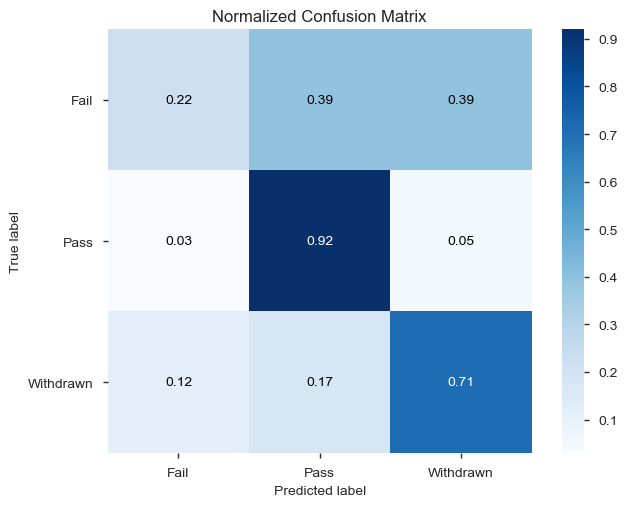

In [28]:
## Define the grid of logistic regression parameters
parameters = [{'penalty': ['l1', 'l2'],
               'C':[0.01, 0.1, 1, 10, 100]}]

lr = LogisticRegression()
    
## Perform grid search CV to find best model parameter setting
lr = GridSearchCV(estimator= lr, param_grid= parameters, cv=3)
lr.fit(xTrain, yTrain)

print('Best hyper-params:',lr.best_params_)
## Fit logistic regression with best parameters to the entire training data
lr = LogisticRegression(penalty= lr.best_params_['penalty'],
                           C= lr.best_params_['C'], random_state=0)
lr.fit(xTrain, yTrain)

# Making predictions on test data
logR_test_pred = lr.predict(xTest)

## Measure test accuracy
logR_test_acc = lr.score(xTest, yTest)
print('Logistic classifier accuray:', round(logR_test_acc,3))

## Measure test recall
logR_test_recall = recall_score(yTest,logR_test_pred, average=None)
print('Logistic classifier recall:', logR_test_recall)

# Confusion Matrix
skplt.metrics.plot_confusion_matrix(yTest, logR_test_pred, normalize=True)
plt.show()

### 2. kNN

Best hyper-params: {'n_neighbors': 15}
kNN classifier accuray: 0.58
kNN classifier recall: [0.23133415 0.82800983 0.38166189]


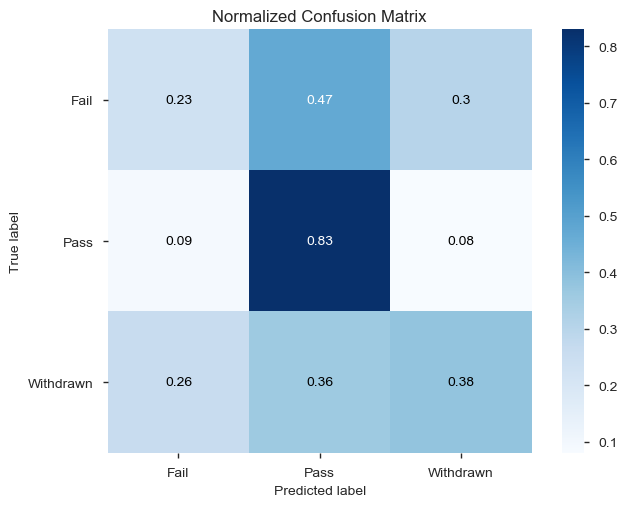

In [29]:
# Define param_map for different values of k
param_grid = {'n_neighbors':[ 3, 5, 7, 9, 11, 13, 15, 19]}

kNN = KNeighborsClassifier(p=2) 

# instantiate GridSearchCV
kNN = GridSearchCV(estimator=kNN, param_grid=param_grid,cv =5 ) 
kNN.fit(xTrain, yTrain)

print('Best hyper-params:',kNN.best_params_)

# Fit a KNeighborsClassifier using the best parameters from grid search. 
kNN = KNeighborsClassifier(n_neighbors=kNN.best_params_['n_neighbors'], p=2) 
kNN.fit(xTrain, yTrain)

# performance on Test Data
print('kNN classifier accuray:', round(accuracy_score(yTest, kNN.predict(xTest)),2))
print('kNN classifier recall:', recall_score(yTest, kNN.predict(xTest), average = None))

# Confusion Matrix
skplt.metrics.plot_confusion_matrix(yTest, kNN.predict(xTest), normalize=True)
plt.show()

### 3. Random Forest

Best hyper-params: {'max_depth': 20}
Random Forest classifier accuray: 0.714
Random Forest classifier recall: [0.29375765 0.93993994 0.63438395]


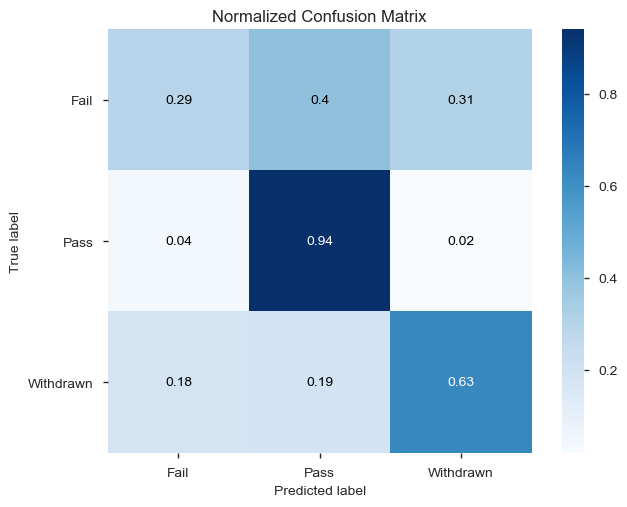

In [30]:
# Define param_map 
param_grid = {'max_depth': [10,20]}

rf = RandomForestClassifier(n_estimators=1000, random_state=0, criterion = 'gini')

# instantiate GridSearchCV
rf = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3)

# Fit a Random Forest using the best parameters from grid search. 
rf.fit(xTrain, yTrain)

print('Best hyper-params:', rf.best_params_)

# performance on Test Data
print('Random Forest classifier accuray:', round(accuracy_score(yTest, rf.predict(xTest)),3))
print('Random Forest classifier recall:', recall_score(yTest, rf.predict(xTest), average = None))

# Confusion Matrix
skplt.metrics.plot_confusion_matrix(yTest, rf.predict(xTest), normalize=True)
plt.show()

### 4. Support Vector Machine 

In [31]:
# svc= SVC()
# param_grid = [ {'C': [1], 'kernel': ['rbf']} ]


# grid=GridSearchCV(svc, param_grid, cv = 3 )

# grid.fit(xTrain,yTrain)

# print('best hyper parameter setting', grid.best_params_)
# svc = grid.best_estimator_

# y_pred_svc = svc.predict(xTest)
# ## computing and plotting confusion matrix

# mat = confusion_matrix(yTest, y_pred_svc)
# print(mat)
# sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
# plt.xlabel('true label')
# plt.ylabel('predicted label')
# plt.show()

### 5. XGBoost Model

In [32]:
regex = re.compile(r"\[|\]|<", re.IGNORECASE)

xTrain.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<')))
                  else col for col in xTrain.columns.values]
xTest.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<')))
                 else col for col in xTest.columns.values]


Best hyper-params: {'max_depth': 5}
Accuracy: 71.71%
Recall  [0.3255814  0.93093093 0.63495702]


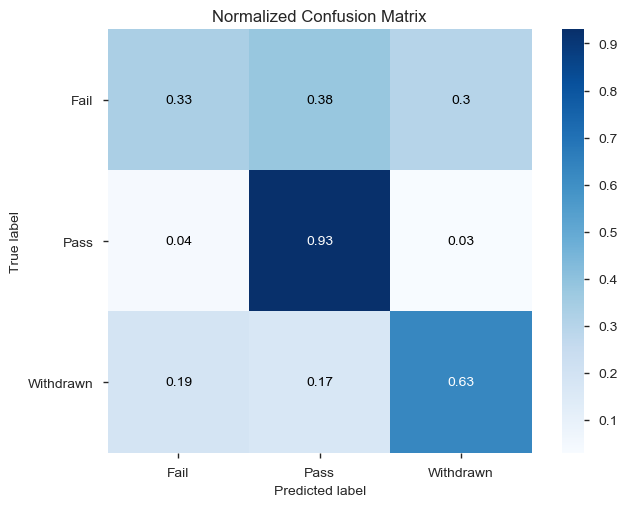

In [40]:
param_grid = {'max_depth': [5,10,20]}

xgb = XGBClassifier(n_estimators = 200, random_state = 1)
grid = GridSearchCV(estimator = xgb, param_grid = param_grid, cv = 3)

# Fit the random search model
grid.fit(xTrain, yTrain)

print('Best hyper-params:', grid.best_params_)

# xgb = xgb.best_estimator_
y_pred = grid.predict(xTest)

accuracy = accuracy_score(yTest, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
recall = recall_score(yTest, y_pred, average=None)
print("Recall " , (recall))

skplt.metrics.plot_confusion_matrix(yTest, y_pred, normalize=True)
plt.show()

#### Based on the performance of different models, XG Boost Model is selected as the final model. 

#### XG Boost Model has both high accuracy and recall

In [42]:
modelFinal = XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=1)
modelFinal.fit(xTrain, yTrain)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=1,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)



### Identifying the Important Features  

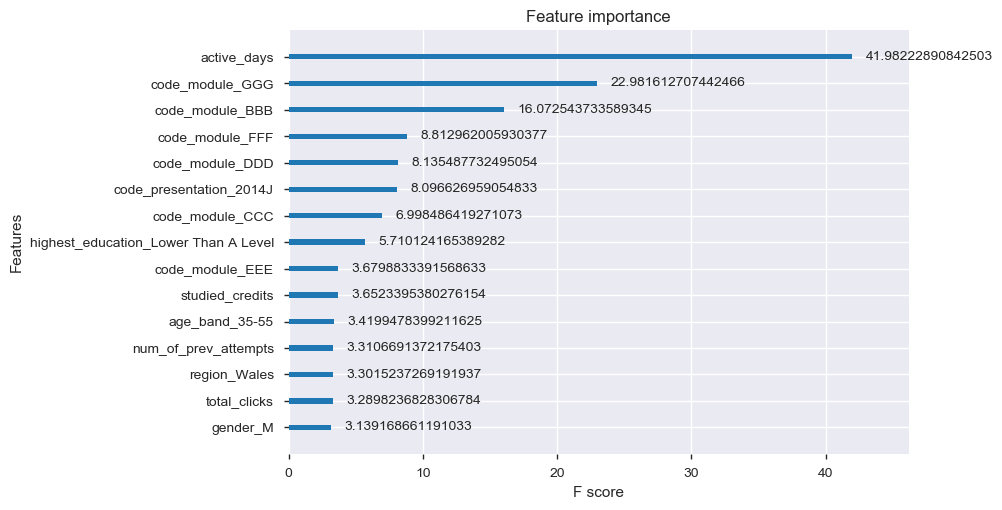

In [43]:
from xgboost import plot_importance

plot_importance(modelFinal, importance_type='gain', max_num_features=15)
plt.rcParams["figure.figsize"] = (6,10)

plt.show()